In [12]:
import numpy as np
import pandas as pd
import lennardjones as lj

import matplotlib.pyplot as plt

In [6]:
df_dataframe = pd.read_csv('/Users/alysonspitzig/Documents/GitHub/nc_AFM/lennardjones/example_data/df_dataframe_237K.csv')

z_piezo = np.genfromtxt('/Users/alysonspitzig/Documents/GitHub/nc_AFM/lennardjones/example_data/z_piezo.csv')


In [35]:
a = 0.5*10**-9
k = 1800
f_0 = 19796.5

z_real = z_piezo - z_piezo[0] +1*10**(-9)

In [36]:
force_0p75 = lj.calculate_force(a,k,f_0, z_real, df_dataframe['0.75'])

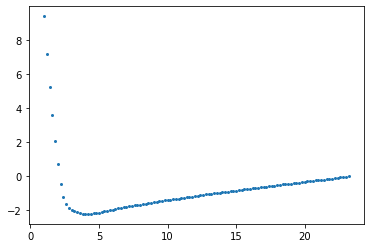

In [43]:
plt.scatter(z_real[:-1]*10**9, lj.calculate_force(a,k,f_0, z_real, df_dataframe['0.75'])*10**9, s= 4, label = '0.75 V')


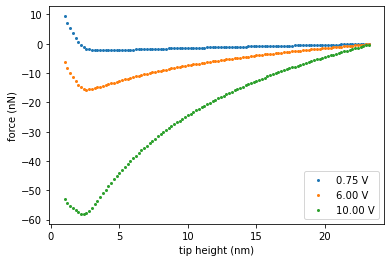

In [41]:
plt.scatter(z_real[:-1]*10**9, lj.calculate_force(a,k,f_0, z_real, df_dataframe['0.75'])*10**9, s= 4, label = '0.75 V')

plt.scatter(z_real[:-1]*10**9, lj.calculate_force(a,k,f_0, z_real, df_dataframe['6.0'])*10**9, s= 4, label = '6.00 V')

plt.scatter(z_real[:-1]*10**9, lj.calculate_force(a,k,f_0, z_real, df_dataframe['10.0'])*10**9, s= 4, label = '10.00 V')

plt.ylabel('force (nN)')
plt.xlabel('tip height (nm)')
plt.legend();

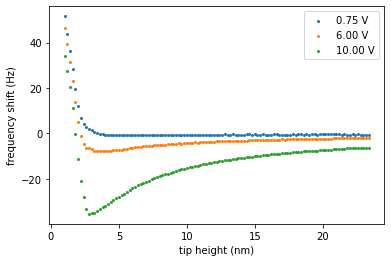

In [42]:
plt.scatter(z_real*10**9, df_dataframe['0.75'], s= 4, label = '0.75 V')

plt.scatter(z_real*10**9, df_dataframe['6.0'], s= 4, label = '6.00 V')

plt.scatter(z_real*10**9, df_dataframe['10.0'], s= 4, label = '10.00 V')

plt.ylabel('frequency shift (Hz)')
plt.xlabel('tip height (nm)')

plt.legend();